Importing libraries

In [8]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import os, fnmatch
import librosa
from sklearn.preprocessing import LabelEncoder

Unzip dataset

In [ ]:
!unzip '/content/Strings.zip'

Getting the filename of audio

In [9]:
path='/content/Strings'

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 4476 audio files in /content/Strings


Giving instrument labels to files

In [10]:
labels =[]
classes=['banjo','cello','double bass','guitar','mandolin','viola','violin']

for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            break
    else:
        labels.append('other')

In [11]:
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

7 classes: banjo, cello, double bass, guitar, mandolin, viola, violin


Extracting audio features with Librosa

In [12]:
fs = 44100        # Sampling Frequency
#n_fft = 2048       # length of the FFT window
#hop_length = n_fft/2   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

In [13]:
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,axis = 1)
    return feature_vector

feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d feature vectors"%len(feature_vectors))

Calculated 4476 feature vectors


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)
scaled_feature_vectors


Feature vectors shape: (4476, 13)


array([[ 1.13752051, -1.22905804, -1.5040446 , ...,  1.3917994 ,
         1.21782931, -0.33539414],
       [-0.88631766, -1.1354585 , -0.45266144, ..., -0.57363876,
        -0.590416  , -1.10848115],
       [ 0.77099964, -1.3020459 , -1.22250578, ..., -1.80449392,
        -1.07052008, -0.801783  ],
       ...,
       [-2.24572775, -0.96771343,  1.43028155, ..., -0.34050457,
        -0.19655643,  0.09804066],
       [-2.13989141, -0.99428981,  1.26419533, ..., -0.47813802,
        -0.03022125,  0.67837291],
       [-1.07001607,  0.4030392 ,  2.14655337, ..., -0.30433681,
        -0.11130324,  0.55303559]])

In [15]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    Xtr = scaled_feature_vectors[train_index]
    Xts = scaled_feature_vectors[test_index]
    ytr = classes_num[train_index]
    yts = classes_num[test_index]

 Building a Neural Network Classifier

In [16]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation

import tensorflow.keras.backend as K
K.clear_session()


In [17]:
nin = Xtr.shape[1]
nout = np.max(ytr)+1
nh = 256

model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               3584      
_________________________________________________________________
output (Dense)               (None, 7)                 1799      
Total params: 5,383
Trainable params: 5,383
Non-trainable params: 0
_________________________________________________________________


Create an optimizer and compile the model

In [18]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [19]:
hist = model.fit(Xtr, ytr, epochs=10, batch_size=100,validation_data=(Xts,yts))

Epoch 1/10
34/34 [==============================] - 0s 6ms/step - loss: 1.4845 - accuracy: 0.4465 - val_loss: 1.2384 - val_accuracy: 0.6148
Epoch 2/10
34/34 [==============================] - 0s 2ms/step - loss: 1.1091 - accuracy: 0.6822 - val_loss: 1.0195 - val_accuracy: 0.6783
Epoch 3/10
34/34 [==============================] - 0s 2ms/step - loss: 0.9347 - accuracy: 0.7283 - val_loss: 0.8919 - val_accuracy: 0.7158
Epoch 4/10
34/34 [==============================] - 0s 2ms/step - loss: 0.8217 - accuracy: 0.7510 - val_loss: 0.7956 - val_accuracy: 0.7328
Epoch 5/10
34/34 [==============================] - 0s 2ms/step - loss: 0.7397 - accuracy: 0.7685 - val_loss: 0.7252 - val_accuracy: 0.7408
Epoch 6/10
34/34 [==============================] - 0s 2ms/step - loss: 0.6748 - accuracy: 0.7834 - val_loss: 0.6698 - val_accuracy: 0.7542
Epoch 7/10
34/34 [==============================] - 0s 2ms/step - loss: 0.6249 - accuracy: 0.7954 - val_loss: 0.6242 - val_accuracy: 0.7712
Epoch 8/10
34/34 [==

Text(0, 0.5, 'Test accuracy')

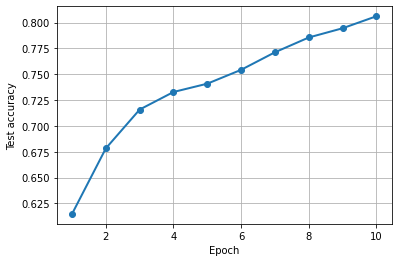

In [20]:
val_acc = hist.history['val_accuracy']
nepochs = len(val_acc)
plt.plot(np.arange(1,nepochs+1), val_acc, 'o-', linewidth=2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')

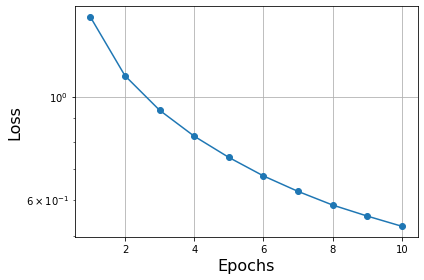

In [21]:
loss = hist.history['loss']
plt.semilogy(np.arange(1,nepochs+1), loss, 'o-')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
plt.tight_layout()